Importing necessary libraries

In [121]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import grangercausalitytests
import networkx as nx
import matplotlib.pyplot as plt
from PyIF import te_compute as te

Base functions

In [122]:
def format_COVID_DataBase(_db): 
    # Query the database to get the only a specific group of data    
    filtered_db = _db.query("demographic_category == 'Age Group'")
    
    #drop values in 'demographic_value' column that are not valid
    filtered_db = filtered_db[filtered_db['demographic_value'].isin(['0-17', '18-49', '50-64', '65+'])]
    
    # copy demographic_value column to a new column called 'label'
    label = filtered_db['demographic_value']

    # drop columns that are not needed
    filtered_db = filtered_db.drop(['demographic_category', 'report_date'], axis=1)

    newDB = np.zeros((509,  5, 4))
    newDB[:,:,:] = np.NaN

    groups = ['0-17', '18-49', '50-64', '65+']
    # create a new database with the data in the correct format
    for agegroup in groups:
        newDB[:,:,groups.index(agegroup)] = filtered_db.query("demographic_value == @agegroup").drop(['demographic_value'], axis=1).to_numpy()
        
    return label, newDB

Granger Causality

In [123]:
#find the minimum pvalue in Granger Causality test result dictionary
def find_min_pvalue(gc_result_dict):
  min_pvalue = 1.0
  for lag_key, lag_result in gc_result_dict.items():
    #print(f'Lag: {lag_key}')    
    
    for test_key, test_result in lag_result[0].items():
      if test_key != "params_ftest":
        pvalue =  test_result[1]
        if pvalue < min_pvalue:
          min_pvalue = pvalue
      
  #print('\n'f"final p-value: {min_pvalue}")
  return min_pvalue


def create_granger_matrix(dataset, max_lags=3):
  matrix = []
  #noColumns = len(dataset.columns)
  for i in range(0,4):
    row = []
    for j in range(0,4):
      pvalue = -1
      for k in range(0,4):
        #print('\n=======\n'f'Checking if column {j} granger causes column {i}')
        #calculate granger causality results
        gc_ji_result = grangercausalitytests(dataset[:,k,[j,i]],max_lags, verbose=False)
        #get p-value
        #pvalue = gc_result[3][0]['lrtest'][1]
        l_pvalue = find_min_pvalue(gc_ji_result)
        if l_pvalue > pvalue: 
          pvalue = l_pvalue
        #print (f"pvalue: {pvalue}")
        #append pvalue in row
      row.append(pvalue)
    #append row in matrix
    matrix.append(row)
  #return matrix
  return matrix

Create Visual Graph

In [124]:
def generate_graph_from_dataframe(data):
  graph = nx.DiGraph()
  data_values = data.values
  
  for row in range(0,len(data_values)): 
    for column in range(0,len(data_values)):
      if data_values[row][column]: 
        graph.add_edge(row,column)
  return graph

def generate_graph_from_matrix(matrix):
    gc_pvalues = pd.DataFrame(matrix)

    threshold = 0.01
    gc_boolean = gc_pvalues.applymap(lambda x: int(x<threshold))

    graph = nx.DiGraph()

    gen_graph = generate_graph_from_dataframe(gc_boolean)
    nx.draw_circular(gen_graph, with_labels=True)

In [125]:
def generate_and_plot_graph_from_matrix(_matrix, _threshold):
  plt.figure(figsize=(10,8))
  _graph = nx.DiGraph()
  pos = nx.spring_layout(_graph)

  edges = []
  for row in range(0,_matrix.shape[0]): 
    for column in range(0,_matrix.shape[1]):
      if ((row != column) & (_matrix[row][column] > _threshold)):
        #print(f'({column},{row}) = {round(_matrix[row][column],5)}')
        edges.append((column,row,round(_matrix[row][column],5)))
        _graph.add_edge(column, row, weight=round(_matrix[row][column],3))
        #_graph.add_edge(column, row, color=column, width=(10*_matrix[row][column]), label=_matrix[row][column])
  
  pos = nx.circular_layout(_graph)
  nx.draw(_graph, pos, with_labels=True, font_weight='bold')
  edge_weight = nx.get_edge_attributes(_graph,'weight')
  nx.draw_networkx_edge_labels(_graph, pos, label_pos=0.2, edge_labels=edge_weight)
  plt.show()

  #print(f'\nArestas (threshold = {_threshold}):\n {edges}')

  return _graph

Transfer Entropy

In [ ]:
def create_transfer_entropy_matrix(dataset):
  matrix = []
  noColumns = len(dataset.columns)
  for i in range(0,noColumns):
    row = []
    for j in range(0,noColumns):
      print(f'Checking transfer entropy of column {j} towards column {i} \n')
      #calculate granger causality results
      te_ji_result = te.te_compute(dataset.iloc[:,j].to_numpy(),dataset.iloc[:,i].to_numpy())
      #get p-value
      #pvalue = gc_result[3][0]['lrtest'][1]
      #pvalue = find_min_pvalue(gc_ji_result)
      #print (f"pvalue: {pvalue}")
      #append pvalue in row
      row.append(te_ji_result)
    #append row in matrix
    matrix.append(row)
  #return matrix
  return matrix

Base Program

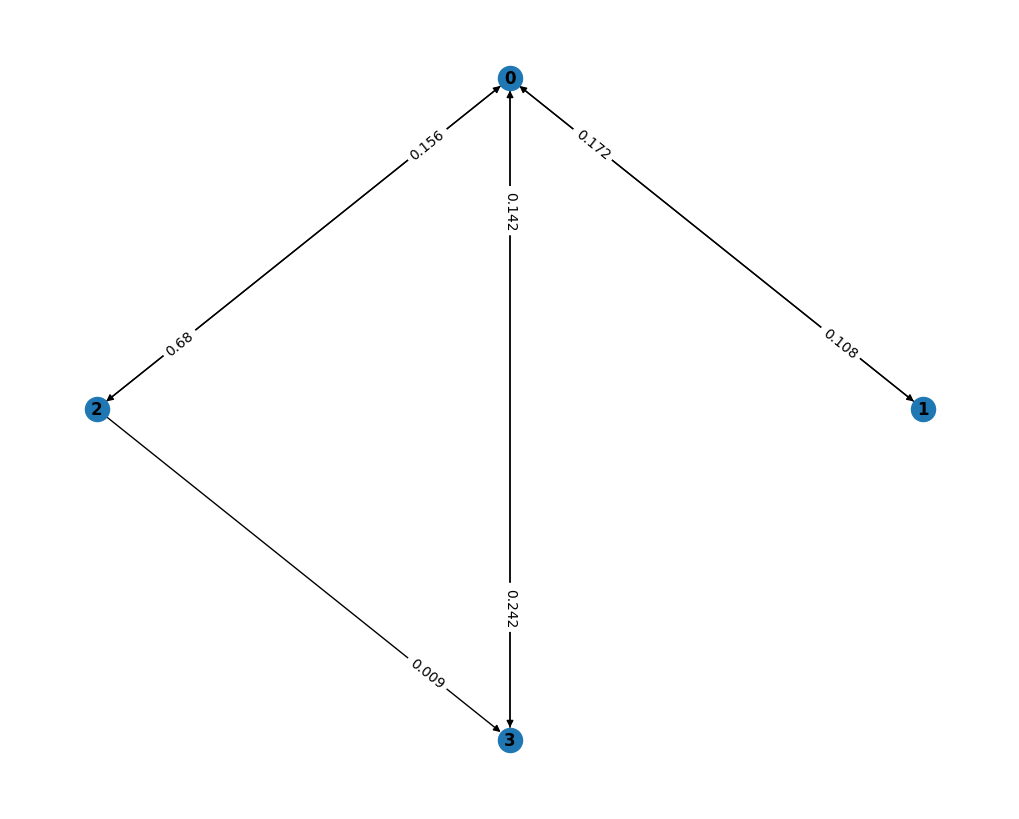

In [126]:
in_db = pd.read_csv('demographics.csv')
label, formated_db = format_COVID_DataBase(in_db)


# Prepare the train and test database
scaler = MinMaxScaler((-1,1))

for i in range(0, 4):
   # Fit database to scaler
   scaler.fit(formated_db[:,:,i])

   # Now apply the transformations to the data:
   formated_db[:,:,i] = scaler.transform(formated_db[:,:,i])


theMatrix = create_granger_matrix(formated_db, max_lags=3)
#generate_graph_from_matrix(theMatrix)
#gen_graph_causality = generate_and_plot_graph_from_matrix(pd.DataFrame(theMatrix), 0.001)
